# Nepal Earthquake Prediction Challenge

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import yeojohnson
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
import xgboost
import shap

## Import Dataset

In [2]:
raw_train = pd.read_csv('train_values.csv')
raw_label = pd.read_csv('train_labels.csv')
df = pd.merge(raw_train, raw_label, how="left", on="building_id")
df['damage_grade'] = df['damage_grade'] - 1
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,1
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,2
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,1
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

## Explatory Data Analysis

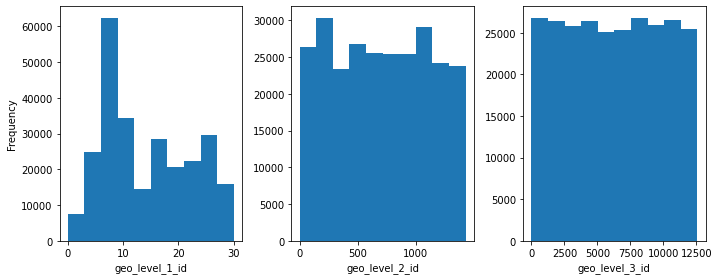

In [4]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.hist(df['geo_level_1_id'])
plt.ylabel("Frequency")
plt.xlabel("geo_level_1_id")

plt.subplot(1, 3, 2)
plt.hist(df['geo_level_2_id'])
plt.xlabel("geo_level_2_id")

plt.subplot(1, 3, 3)
plt.hist(df['geo_level_3_id'])
plt.xlabel("geo_level_3_id")

plt.tight_layout()
plt.show()

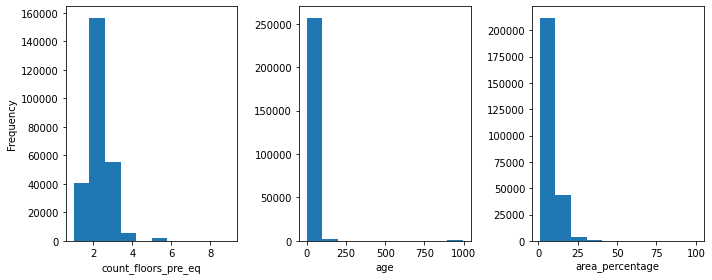

In [5]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.hist(df['count_floors_pre_eq'])
plt.ylabel("Frequency")
plt.xlabel("count_floors_pre_eq")

plt.subplot(1, 3, 2)
plt.hist(df['age'])
plt.xlabel("age")

plt.subplot(1, 3, 3)
plt.hist(df['area_percentage'])
plt.xlabel("area_percentage")

plt.tight_layout()
plt.show()

...

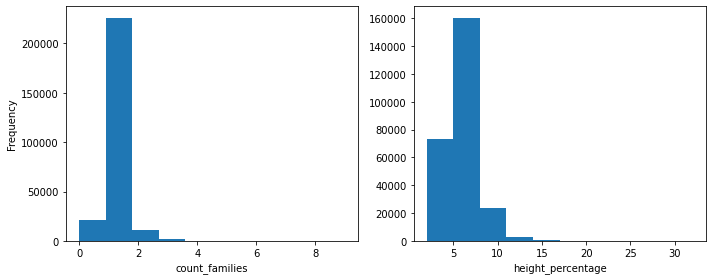

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['count_families'])
plt.ylabel('Frequency')
plt.xlabel('count_families')

plt.subplot(1, 2, 2)
plt.hist(df['height_percentage'])
plt.xlabel('height_percentage')
plt.tight_layout()
plt.show()

In [7]:
def convert_count_floors_pre_eq(val):
    if val >= 4:
        return "4+"
    else:
        return str(val)

def convert_count_families(val):
    if val >= 3:
        return "3+"
    else:
        return str(val)

In [8]:
df['new_count_floor_pre_eq'] = df['count_floors_pre_eq'].apply(convert_count_floors_pre_eq)
df['new_count_families'] = df['count_families'].apply(convert_count_families)
df['age_transform'] = yeojohnson(df['age'])[0]
df['area_percentage_transform'] = np.log(df['area_percentage'])
df['height_percentage_transform'] = np.log(df['height_percentage'])

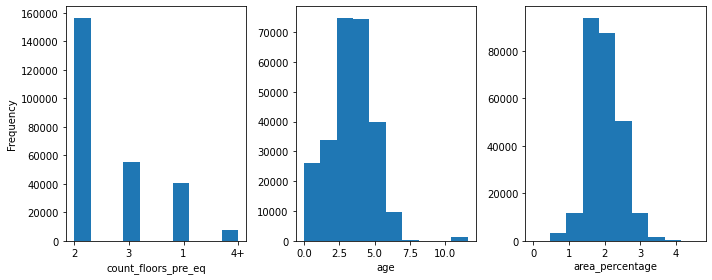

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.hist(df['new_count_floor_pre_eq'])
plt.ylabel("Frequency")
plt.xlabel("count_floors_pre_eq")

plt.subplot(1, 3, 2)
plt.hist(df['age_transform'])
plt.xlabel("age")

plt.subplot(1, 3, 3)
plt.hist(df['area_percentage_transform'])
plt.xlabel("area_percentage")

plt.tight_layout()
plt.show()

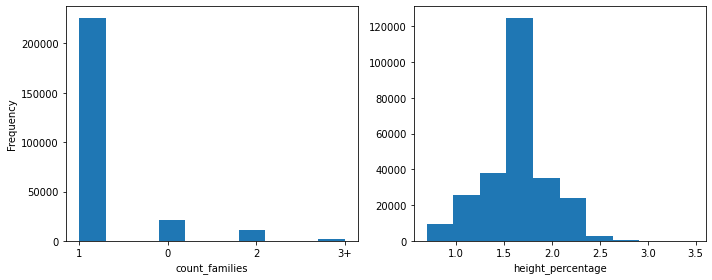

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['new_count_families'])
plt.ylabel('Frequency')
plt.xlabel('count_families')

plt.subplot(1, 2, 2)
plt.hist(df['height_percentage_transform'])
plt.xlabel('height_percentage')
plt.tight_layout()
plt.show()

In [11]:
q75, q25 = np.percentile(df['age_transform'], [75 ,25])
iqr = q75 - q25
outlier_range = (q25 - 1.5*iqr, q75 + 1.5*iqr)

In [12]:
# remove outliers
df = df[(df['age_transform'] > outlier_range[0]) &
        (df['age_transform'] < outlier_range[1])
        ]

## Creating Model

In [13]:
numerical = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
             'height_percentage_transform', 'area_percentage_transform', 'age_transform']

categorical = ['new_count_families', 'new_count_floor_pre_eq', 'land_surface_condition',
               'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
               'position', 'plan_configuration', 'legal_ownership_status']

binary = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
          'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
          'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
          'has_superstructure_timber', 'has_superstructure_bamboo',
          'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered',
          'has_superstructure_other', 'has_secondary_use',
          'has_secondary_use_agriculture', 'has_secondary_use_hotel',
          'has_secondary_use_rental', 'has_secondary_use_institution',
          'has_secondary_use_school', 'has_secondary_use_industry',
          'has_secondary_use_health_post', 'has_secondary_use_gov_office',
          'has_secondary_use_use_police', 'has_secondary_use_other']

In [14]:
numeric_transformer = Pipeline(
    steps=[("identity", FunctionTransformer())]
)

categorical_transformer = Pipeline(
    steps=[("ordinal", OrdinalEncoder())]
)

binary_transformer = Pipeline(
    steps=[("ordinal", FunctionTransformer())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical),
        ("cat", categorical_transformer, categorical),
        ("binary", binary_transformer, binary)
    ]
)

In [15]:
train = df[numerical + categorical + binary]
label = df['damage_grade']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, shuffle=True)

In [17]:
pipeline = preprocessor.fit(X_train)
train_x, test_x = pipeline.transform(X_train), pipeline.transform(X_test)

## Fit XGBoost and get SHAP value

In [18]:
dm_train = xgboost.DMatrix(train_x, label=y_train,
                           feature_names=pipeline.feature_names_in_)

In [19]:
param = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'nthread': -1
}

model = xgboost.train(param, dm_train)

[21:40:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Feature Importance Plot

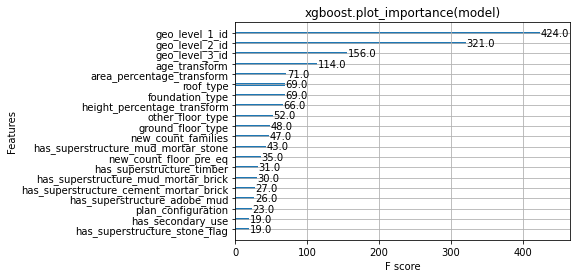

In [20]:
xgboost.plot_importance(model, max_num_features=20)
plt.title("xgboost.plot_importance(model)")
plt.show()

### SHAP Value

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dm_train)

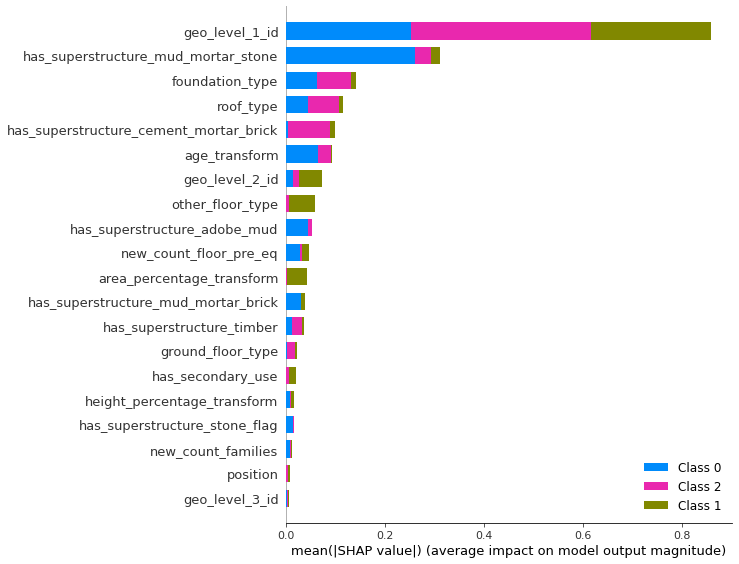

In [22]:
shap.summary_plot(shap_values, plot_type="bar",
                  feature_names=pipeline.feature_names_in_)

## Baseline Model

In [23]:
dm_test_baseline = xgboost.DMatrix(test_x, feature_names=pipeline.feature_names_in_)

In [24]:
predict_baseline = model.predict(dm_test_baseline)

In [25]:
f1_score(y_test, predict_baseline, average='micro')

0.6888984416980118

## Feature Selection

### Variables based on SHAP Value

In [75]:
numeric_shap = ['geo_level_1_id', 'age_transform', 'geo_level_2_id']

categorical_shap = ['foundation_type', 'roof_type', 'other_floor_type',
                    'new_count_floor_pre_eq']

binary_shap = ['has_superstructure_mud_mortar_stone', 'has_superstructure_cement_mortar_stone',
               'has_superstructure_mud_mortar_brick']

### Variables based on feature importance

In [76]:
numeric_fi = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'age_transform',
              'area_percentage_transform', 'height_percentage_transform']

categorical_fi = ['foundation_type', 'roof_type', 'new_count_families']

binary_fi = ['has_superstructure_mud_mortar_stone']

### Pipeline

In [77]:
data_shap = df[numeric_shap + categorical_shap + binary_shap]
data_fi = df[numeric_fi + categorical_fi + binary_fi]

label = df['damage_grade']

In [78]:
preprocessor_shap = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_shap),
        ("cat", categorical_transformer, categorical_shap),
        ("binary", binary_transformer, binary_shap)
    ]
)

preprocessor_fi = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_fi),
        ("cat", categorical_transformer, categorical_fi),
        ("binary", binary_transformer, binary_fi)
    ]
)

In [79]:
pipeline_shap = preprocessor_shap.fit(data_shap)
pipeline_fi = preprocessor_fi.fit(data_fi)

In [80]:
# convert values in pipeline
data_transform_shap = pipeline_shap.transform(data_shap)
data_transform_fi = pipeline_fi.transform(data_fi)

In [81]:
# split to train and test
X_train_shap, X_test_shap, y_train_shap, y_test_shape = train_test_split(data_transform_shap,
                                                                         label,
                                                                         test_size=0.2,
                                                                         shuffle=True)

X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(data_transform_fi,
                                                                label,
                                                                test_size=0.2,
                                                                shuffle=True)

### Hyperparameter Tuning and finding best model

In [86]:
model = xgboost.XGBClassifier(objective= 'multi:softmax', verbosity=0,
                              use_label_encoder=False)

In [87]:
param_grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0.1, 0.01, 0.001],
    'reg_alpha': [0.1, 0.01, 0.001],
    'reg_lambda': [0.1, 0.01, 0.001]
}

In [88]:
random_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                   n_iter=50,
                                   scoring='f1_micro',
                                   cv=5,
                                   verbose=0)

#### SHAP Value

In [89]:
# fit columns derived from shap value
rs_shap = random_search
rs_shap.fit(X_train_shap, y_train_shap)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [91]:
print(f"Best Parameters: {rs_shap.best_params_}")
print(f"Best micro-f1 score: {rs_shap.best_score_}")

Best Parameters: {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.001}
Best micro-f1 score: 0.7209027404621171


#### Feature Importance

In [92]:
rs_fi = random_search
rs_fi.fit(X_train_fi, y_train_fi)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [93]:
print(f"Best Parameters: {rs_fi.best_params_}")
print(f"Best micro-f1 score: {rs_fi.best_score_}")

Best Parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.01}
Best micro-f1 score: 0.7374476088124665


## Create Prediction Dataset

In [95]:
test_val = pd.read_csv('test_values.csv')
test_val.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


In [97]:
test_val['age_transform'] = yeojohnson(test_val['age'])[0]
test_val['area_percentage_transform'] = np.log(test_val['area_percentage'])
test_val['height_percentage_transform'] = np.log(test_val['height_percentage'])
test_val['new_count_families'] = test_val['count_families'].apply(convert_count_families)

In [98]:
test_val_fi = test_val[numeric_fi + categorical_fi + binary_fi]

In [99]:
preprocessor_test = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_fi),
        ("cat", categorical_transformer, categorical_fi),
        ("binary", binary_transformer, binary_fi)
    ]
)

X_test_final = preprocessor_test.fit_transform(test_val_fi)

In [120]:
dm_train_fi = xgboost.DMatrix(data_transform_fi, label=label)

param_final = {'reg_lambda': 0.1,
               'reg_alpha': 0.01,
               'n_estimators': 1000,
               'max_depth': 5,
               'learning_rate': 0.1,
               'gamma': 0.01,
               'num_class': 3,
               'objective': 'multi:softmax'}

final_model = xgboost.train(param_final, dm_train_fi)

In [121]:
dm_test_final = xgboost.DMatrix(X_test_final)
predict = final_model.predict(dm_test_final)

In [127]:
submit_prediction = pd.DataFrame()
submit_prediction['buiding_id'] = test_val['building_id']
submit_prediction['damage_grade'] = predict + 1
submit_prediction['damage_grade'] = submit_prediction['damage_grade'].apply(lambda x: int(x))

In [128]:
submit_prediction.head()

,buiding_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,2
4,421793,3


In [129]:
submit_prediction.to_csv('submission.csv', index=False)